## Automatic Instance Segmentation with SAM2

## Enviroment Set-Up

In [1]:
using_colab = False

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/cars.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

## Set-Up

In [3]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1" # quite nice life hack
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from skimage.measure import regionprops
import pandas as pd

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "\ngive numerically different outputs and sometimes degraded performance on MPS. "
        "\nSee e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: mps

Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might 
give numerically different outputs and sometimes degraded performance on MPS. 
See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.


In [5]:
from matplotlib import colormaps
import cv2
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return

    sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img_shape = sorted_anns[0]['segmentation'].shape
    img = np.ones((*img_shape, 4))  # RGBA image
    img[:, :, 3] = 0  # Fully transparent initially

    cmap = colormaps.get_cmap("plasma")  # Get the plasma colormap
    num_colors = len(sorted_anns)  # Number of different colors needed
    color_indices = np.random.rand(num_colors)  # Randomly sample colors

    for i, ann in enumerate(sorted_anns):
        m = ann['segmentation']
        color = cmap(color_indices[i])  # Get a random color from plasma colormap
        color_mask = np.array([color[0], color[1], color[2], 0.5])  # RGBA with alpha

        img[m] = color_mask  # Assign color to segmentation mask

        if borders:
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)  # Draw blue borders

    ax.imshow(img)

## Load Image

In [6]:
folder_path = "/Volumes/warm_SD/data/160/00_series/00"
image_list = sorted(os.listdir(folder_path))
print(image_list)

['.DS_Store', '160_01_50x', '160_01_50x.tiff', '160_02_50x', '160_02_50x.tiff', '160_03_50x', '160_03_50x.tiff']


Loading image from /Volumes/warm_SD/data/160/00_series/00/160_01_50x.tiff
Converting image from L to RGB
shape: (2234, 23050, 3),dtype: uint8
shape: (1024, 4048, 3),dtype: uint8


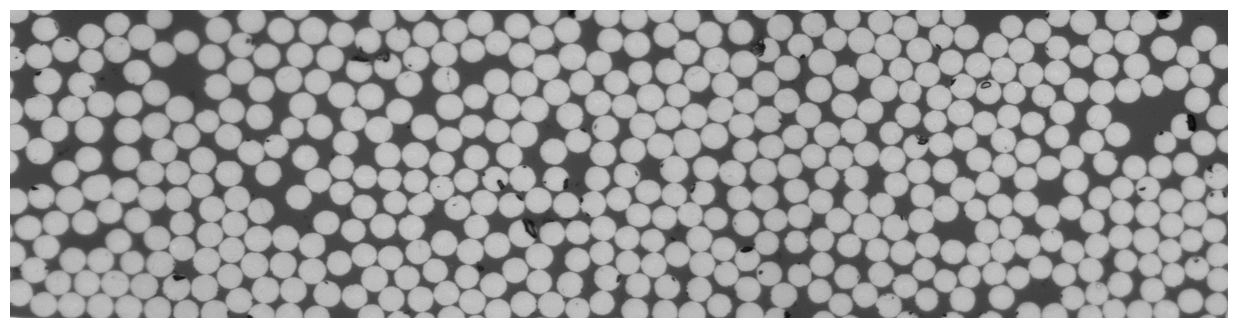

In [13]:
file_name = image_list[2]
file_name_no_ext, file_ext = os.path.splitext(file_name)
file_path = os.path.join(folder_path,file_name)
print(f"Loading image from {file_path}")
image = Image.open(file_path)
if not image.mode == "RGB":
    print(f"Converting image from {image.mode} to RGB")
    image = np.array(image.convert("RGB"))
print(f"shape: {image.shape},dtype: {image.dtype}")

## just for prototyping select a smaller patch
image = image[450:1474,5000:9048,:]
print(f"shape: {image.shape},dtype: {image.dtype}")

plt.figure(figsize=(20, 4))
plt.imshow(image)
plt.axis('off')
plt.show()

## Dissamble Image in handy Patches 

## Helper Functions

In [14]:
# --- Tiler/Patcher Helper Functions ---------------------------------------------------
def _positions(full, win, overlap):
    if not (0 <= overlap < win): raise ValueError("0 <= overlap < win required")
    if full <= win: return [0]
    stride = win - overlap
    pos = [0]
    x = 0
    while True:
        x += stride
        if x + win >= full:
            last = max(0, full - win)
            if last != pos[-1]: pos.append(last)
            break
        pos.append(x)
    return pos

def tile_numpy(img, patch_h, patch_w, overlap_h=0, overlap_w=0, pad_mode="reflect", pad_value=0):
    """
    img: np.ndarray (H, W, 3)
    returns: patches (N, patch_h, patch_w, 3), offsets [(y0,x0), ...], padded_shape
    """
    assert img.ndim == 3 and img.shape[-1] == 3, "Expected (H,W,3)"
    H, W, _ = img.shape
    ys = _positions(H, patch_h, overlap_h)
    xs = _positions(W, patch_w, overlap_w)

    pad_bottom = max(0, (ys[-1] + patch_h) - H)
    pad_right  = max(0, (xs[-1] + patch_w) - W)
    if pad_bottom or pad_right:
        pad_cfg = ((0, pad_bottom), (0, pad_right), (0,0))
        if pad_mode == "reflect":
            img_p = np.pad(img, pad_cfg, mode="reflect")
        elif pad_mode == "constant":
            img_p = np.pad(img, pad_cfg, mode="constant", constant_values=pad_value)
        else:
            raise ValueError("pad_mode must be 'reflect' or 'constant'")
    else:
        img_p = img

    patches, offsets = [], []
    for y0 in ys:
        for x0 in xs:
            patches.append(img_p[y0:y0+patch_h, x0:x0+patch_w, :])
            offsets.append((y0, x0))

    return np.stack(patches, axis=0), offsets, img_p.shape
# -----------------------------------------------------------------------------

In [15]:
# img: (H,W,3)
patches, offsets, padded_shape = tile_numpy(image, patch_h=1024, patch_w=1024,
                                            overlap_h=128, overlap_w=128,
                                            pad_mode="reflect")
print(patches.shape)
# patches.shape -> (N, 512, 512, 3)

(5, 1024, 1024, 3)


number of patches: 5
plotting 5 patches


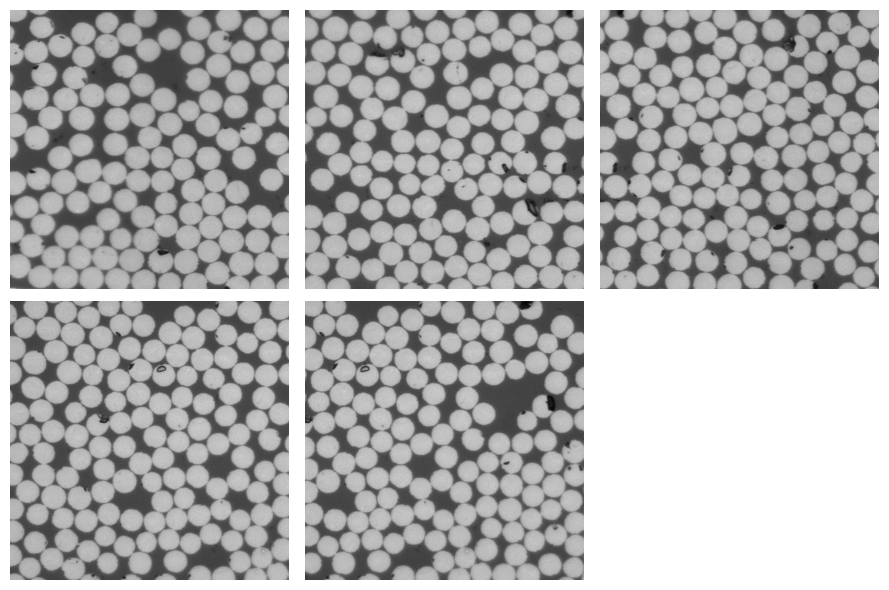

In [16]:
n = patches.shape[0]
print(f"number of patches: {n}")
# visualize a few patches 
n_limit = 30
n_plot = min(n, n_limit)
print(f"plotting {n_plot} patches")

# decide rows (m) and cols (k)
if n_plot < 5:
    m, k = 1, n_plot
else:
    m = 2
    k = (n_plot + 1) // 2   # split into 2 rows, round up

fig, axs = plt.subplots(m, k, figsize=(3*k, 3*m))
axs = np.atleast_1d(axs).flatten()

for i in range(n_plot):
    axs[i].imshow(patches[i])
    axs[i].axis("off")

# turn off unused subplots (if any)
for j in range(n_plot, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()


## Automatic mask generation per image Patch

In [22]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2,
        points_per_side=32, # correspond to 16**2 = 256 detection points which is similar to fibers per patch
        points_per_batch=96, # Sets the number of points run simultaneously by the model. Higher numbers may be faster but use more GPU memory
        pred_iou_thresh=0.1,
        # min_mask_region_area=500,
        box_nms_thresh=0.1,
        stability_score_thresh=0.95,  # Reduce the stability threshold to keep more masks
            )

In [23]:
from time import time
masks = []
time_accum = 0
for i, patch in enumerate(patches):
    time_start = time()
    print(f"processing patch {i+1}/{n}")
    masks.append(mask_generator.generate(patch))
    time_end = time()
    time_accum += (time_end - time_start)
    print(f"  time for patch: {time_end - time_start:.2f}s")
print(f"Total time for {n} patches: {time_accum:.2f}s, avg time per patch: {time_accum/n:.2f}s")

processing patch 1/5
  time for patch: 227.38s
processing patch 2/5
  time for patch: 161.73s
processing patch 3/5
  time for patch: 168.19s
processing patch 4/5
  time for patch: 291.02s
processing patch 5/5
  time for patch: 238.92s
Total time for 5 patches: 1087.25s, avg time per patch: 217.45s


number of masks in patch: 127


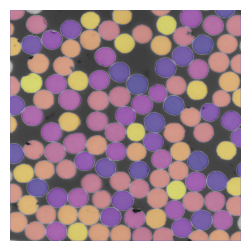

number of masks in patch: 132


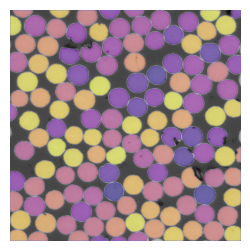

number of masks in patch: 141


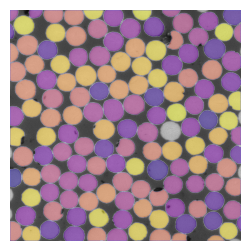

number of masks in patch: 144


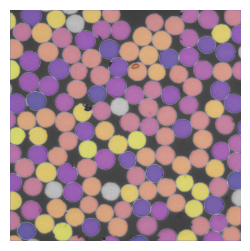

number of masks in patch: 142


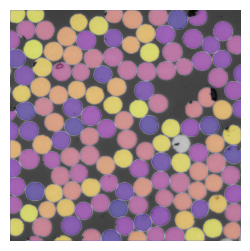

In [24]:
for mask, patch in zip(masks, patches):
    print(f"number of masks in patch: {len(mask)}")
    plt.figure(figsize=(3, 3))
    plt.imshow(patch)
    show_anns(mask)
    plt.axis('off')
    plt.show()

In [25]:
def _iou(a, b):
    inter = np.logical_and(a, b).sum()
    if inter == 0: return 0.0
    union = np.logical_or(a, b).sum()
    return inter / union

def _bbox2d(mask_bool):
    ys, xs = np.where(mask_bool)
    if ys.size == 0:
        return [0, 0, 0, 0], [0, 0, 0, 0]
    y0, x0 = int(ys.min()), int(xs.min())
    y1, x1 = int(ys.max()) + 1, int(xs.max()) + 1
    w, h = x1 - x0, y1 - y0
    return [x0, y0, w, h], [x0, y0, x1, y1]

def _instances_from_maps(inst_map, conf_map):
    """Build SAM2-style dicts per global instance id (>0)."""
    instances = []
    ids = np.unique(inst_map)
    ids = ids[ids > 0]
    for iid in ids:
        seg = (inst_map == iid)
        area = int(seg.sum())
        if area == 0:
            continue
        bbox, crop_box = _bbox2d(seg)
        # aggregate score over pixels of this instance
        scores = conf_map[seg]
        predicted_iou = float(scores.mean()) if scores.size else 0.0
        instances.append({
            "segmentation": seg,          # (H,W) bool in global coords
            "area": area,
            "bbox": bbox,                 # [x, y, w, h] global
            "predicted_iou": predicted_iou,
            "point_coords": [],           # fill if you used prompts
            "stability_score": None,      # fill if you compute it
            "crop_box": crop_box,         # [x0, y0, x1, y1] global
        })
    return instances

def stitch_sam2_instances_with_dicts(
    padded_shape_hw, offsets, per_tile_sam2, merge_iou=0.5, debug=False
):
    """
    Inputs:
      - padded_shape_hw: (H_pad, W_pad)
      - offsets: [(y0,x0), ...] per tile (padded coords)
      - per_tile_sam2: list per tile, each a list of SAM2 dicts with keys:
           'segmentation' (HxW bool in patch coords),
           'bbox' [x,y,w,h] (patch coords),
           'predicted_iou' (float)
        (Other keys are ignored here but passed through later.)
    Returns:
      inst_map_pad, conf_map_pad, instances_list  (SAM2-style per global instance)
    """
    H, W = padded_shape_hw
    inst_map = np.zeros((H, W), dtype=np.int32)
    conf_map = np.zeros((H, W), dtype=np.float32)
    next_id = 1
    total_written = 0

    for (tile_y0, tile_x0), detections in zip(offsets, per_tile_sam2):
        for d in detections:
            # required fields
            m = d["segmentation"].astype(bool, copy=False)
            if not m.any():
                continue
            score = float(d.get("predicted_iou", 1.0))
            x, y, w, h = d.get("bbox", [0, 0, m.shape[1], m.shape[0]])
            if w == 0 or h == 0:
                # fallback to tight bbox from mask
                ys, xs = np.where(m)
                y, x = int(ys.min()), int(xs.min())
                h = int(ys.max() - y + 1)
                w = int(xs.max() - x + 1)

            by0, bx0, by1, bx1 = int(y), int(x), int(y + h), int(x + w)
            gy0, gx0 = tile_y0 + by0, tile_x0 + bx0
            gy1, gx1 = tile_y0 + by1, tile_x0 + bx1

            # bounds clamp
            gy0 = max(0, min(gy0, H)); gy1 = max(0, min(gy1, H))
            gx0 = max(0, min(gx0, W)); gx1 = max(0, min(gx1, W))
            if gy0 >= gy1 or gx0 >= gx1:
                continue

            m_sub  = m[by0:by1, bx0:bx1]
            im_sub = inst_map[gy0:gy1, gx0:gx1]
            cf_sub = conf_map[gy0:gy1, gx0:gx1]

            # find overlaps
            overlapping = np.unique(im_sub[m_sub])
            overlapping = overlapping[overlapping != 0]

            best_iou, tgt = 0.0, None
            for oid in overlapping:
                iou = _iou(m_sub, (im_sub == oid))
                if iou > best_iou:
                    best_iou, tgt = iou, oid

            if tgt is None or best_iou < merge_iou:
                tgt = next_id
                next_id += 1

            # write rule: fill empty, or replace where we’re as good or better
            write = m_sub & ((cf_sub == 0) | (score >= cf_sub))
            total_written += int(write.sum())
            im_sub[write] = tgt
            cf_sub[write] = score

            inst_map[gy0:gy1, gx0:gx1] = im_sub
            conf_map[gy0:gy1, gx0:gx1] = cf_sub

    if debug:
        print(f"[stitch] written_px={total_written}, instances={int(inst_map.max())}")

    # Build SAM2-style dicts per *global* instance from the maps:
    instances = _instances_from_maps(inst_map, conf_map)
    return inst_map, conf_map, instances
# -----------------------------------------------------------------------------

(1024, 4048) int32 531


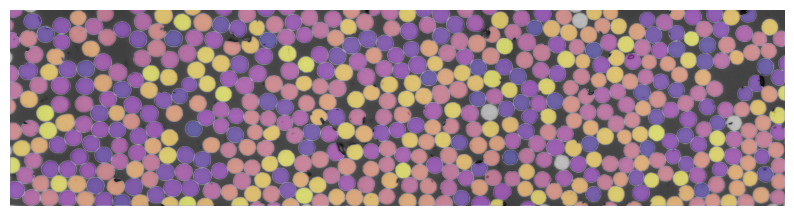

In [26]:
# 3) stitch back
inst_map_pad, conf_map_pad, instances = stitch_sam2_instances_with_dicts(
        padded_shape_hw=padded_shape[:2],
        offsets=offsets,
        per_tile_sam2=masks,
        merge_iou=0.5
    )


# 4) crop back to original image size
H, W, _ = image.shape
inst_map = inst_map_pad[:H, :W]
conf_map = conf_map_pad[:H, :W]


print(inst_map.shape, inst_map.dtype, inst_map.max())

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(instances)
plt.axis('off')
plt.show()

## Save your Results

In [28]:
import io, json, base64
def _mask_to_polygons_fast(mask, level=0.5, min_points=3, min_area_px=50,
                           simplify_tol=2.0, approx_eps_frac=0.002, max_vertices=2000):
    """
    Convert binary mask -> list of Nx2 float polygons [x, y], simplified.
    - min_area_px: drop tiny contours
    - simplify_tol: Douglas–Peucker tol (pixels) if shapely available
    - approx_eps_frac: OpenCV approxPolyDP epsilon = frac * perimeter (fallback)
    - max_vertices: cap vertices per polygon (sample if needed)
    """
    polys = []

    # 1) find contours
    try:
        from skimage import measure
        contours = measure.find_contours(mask.astype(float), level=level)
        # skimage gives (y, x) floats
        for c in contours:
            if c.shape[0] < min_points:
                continue
            # area via polygon shoelace
            xy = np.stack([c[:,1], c[:,0]], axis=1)
            area = 0.5 * np.abs(np.dot(xy[:,0], np.roll(xy[:,1], -1)) - np.dot(xy[:,1], np.roll(xy[:,0], -1)))
            if area < min_area_px:
                continue
            polys.append(xy)
    except Exception:
        # OpenCV fallback
        import cv2
        cnts, _ = cv2.findContours((mask.astype(np.uint8)*255), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for cnt in cnts:
            if cnt.shape[0] < min_points: 
                continue
            xy = cnt[:,0,:].astype(float)
            area = cv2.contourArea(xy.astype(np.float32))
            if area < min_area_px:
                continue
            polys.append(xy)
    
    # 2) simplify
    out = []
    try:
        if len(polys) > 0:
            from shapely.geometry import Polygon
        for xy in polys:
            if xy.shape[0] < 3: 
                continue
            try:
                poly = Polygon(xy).simplify(simplify_tol, preserve_topology=True)
                if poly.is_empty or not poly.exterior:
                    continue
                xy2 = np.array(poly.exterior.coords, dtype=float)
            except Exception:
                xy2 = xy
            # cap vertices
            if xy2.shape[0] > max_vertices:
                idx = np.linspace(0, xy2.shape[0]-1, max_vertices, dtype=int)
                xy2 = xy2[idx]
            if xy2.shape[0] >= min_points:
                out.append(xy2)
    except Exception:
        # Fallback: OpenCV approxPolyDP
        import cv2
        for xy in polys:
            peri = cv2.arcLength(xy.astype(np.float32), True)
            eps = max(1.0, approx_eps_frac * peri)
            approx = cv2.approxPolyDP(xy.astype(np.float32), eps, True)[:,0,:].astype(float)
            if approx.shape[0] > max_vertices:
                idx = np.linspace(0, approx.shape[0]-1, max_vertices, dtype=int)
                approx = approx[idx]
            if approx.shape[0] >= min_points:
                out.append(approx)
    return out

def _encode_image_to_base64(image_path=None, image_np=None):
    """
    Returns (b64_string, image_ext, H, W).
    If image_path is given, reads that file.
    Else uses image_np (H,W[,C]) and encodes as PNG.
    """
    if image_path is not None:
        with open(image_path, "rb") as f:
            data = f.read()
        b64 = base64.b64encode(data).decode("utf-8")
        # infer size only if needed
        try:
            from PIL import Image
            with Image.open(io.BytesIO(data)) as im:
                W, H = im.size
        except Exception:
            H = W = None
        ext = os.path.splitext(image_path)[1].lstrip(".").lower() or "png"
        return b64, ext, H, W

    # encode numpy image to PNG
    assert image_np is not None, "Provide image_path or image_np"
    try:
        from PIL import Image
    except ImportError:
        raise RuntimeError("Pillow required to encode numpy image to PNG.")
    arr = image_np
    if arr.dtype != np.uint8:
        # normalize/convert safely
        arr = np.clip(arr, 0, 255).astype(np.uint8)
    if arr.ndim == 2:
        mode = "L"
    elif arr.ndim == 3 and arr.shape[2] == 3:
        mode = "RGB"
    elif arr.ndim == 3 and arr.shape[2] == 4:
        mode = "RGBA"
    else:
        raise ValueError(f"Unsupported image shape {arr.shape}")
    im = Image.fromarray(arr, mode=mode)
    buf = io.BytesIO()
    im.save(buf, format="PNG")
    data = buf.getvalue()
    b64 = base64.b64encode(data).decode("utf-8")
    H, W = arr.shape[:2]
    return b64, "png", H, W

def save_instances_to_labelme(
    instances,               # list of dicts with 'segmentation' (H,W) bool
    out_json_path,           # where to save .json
    image_path=None,         # optional path to original image (for imagePath)
    image_np=None,           # optional numpy image if no file on disk
    label_prefix="inst",
    simplify_tol=2.0,
    approx_eps_frac=0.002,
    min_area_px=50,
    max_vertices=2000
):
    """
    Writes a Labelme JSON with embedded base64 imageData to avoid 'NoneType' errors.
    """
   
    # --- image embedding (fixes your error) ---
    b64, ext, H_img, W_img = _encode_image_to_base64(image_path=image_path, image_np=image_np)
    if H_img is None or W_img is None:
        # fall back to first instance mask size
        for inst in instances:
            seg = inst["segmentation"]
            H_img, W_img = int(seg.shape[0]), int(seg.shape[1])
            break

    shapes = []
    for idx, inst in enumerate(instances, start=1):
        seg = inst["segmentation"].astype(bool)
        if seg.sum() < min_area_px:
            continue
        polys = _mask_to_polygons_fast(
            seg, min_area_px=min_area_px,
            simplify_tol=simplify_tol, approx_eps_frac=approx_eps_frac,
            max_vertices=max_vertices
        )
        if not polys:
            continue
        polys = _mask_to_polygons_fast(seg, simplify_tol=simplify_tol)
        label = inst.get("label", f"{label_prefix}_{idx}")

        for poly in polys:
            # ensure python floats/lists (not numpy types)
            points = [[float(x), float(y)] for x, y in poly.tolist()]
            shapes.append({
                "label": label,
                "points": points,
                "group_id": int(idx),
                "shape_type": "polygon",
                "flags": {
                    "predicted_iou": float(inst.get("predicted_iou", 0.0)),
                    "area": int(inst.get("area", int(seg.sum()))),
                },
            })

    labelme = {
        "version": "5.4.1",
        "flags": {},
        "shapes": shapes,
        "imagePath": os.path.basename(image_path) if image_path else f"image.{ext}",
        "imageData": b64,               # <— embedded base64 fixes the NoneType error
        "imageHeight": int(H_img),
        "imageWidth": int(W_img),
    }

    os.makedirs(os.path.dirname(out_json_path), exist_ok=True) if os.path.dirname(out_json_path) else None
    with open(out_json_path, "w", encoding="utf-8") as f:
        json.dump(labelme, f, ensure_ascii=False, indent=2)
    print(f"Saved Labelme JSON with embedded image -> {out_json_path} (shapes: {len(shapes)})")


In [29]:
# After stitching:
# inst_map_pad, conf_map_pad, instances = stitch_sam2_instances_with_dicts(...)

for i, (mask, patch) in enumerate(zip(masks,patches)):
    
    file_path_out = f"./annotations/{file_name_no_ext}_{i:03d}.json"
    print(f"writting {file_path_out}")
    save_instances_to_labelme(
        instances=mask,
        out_json_path=file_path_out,
        image_np=patch,   # (H,W[,C]) uint8
        label_prefix="fiber",
        simplify_tol=.5,
        approx_eps_frac=0.002,
        min_area_px=50,
        max_vertices=1000
    )

writting ./annotations/160_01_50x_000.json
Saved Labelme JSON with embedded image -> ./annotations/160_01_50x_000.json (shapes: 127)
writting ./annotations/160_01_50x_001.json
Saved Labelme JSON with embedded image -> ./annotations/160_01_50x_001.json (shapes: 132)
writting ./annotations/160_01_50x_002.json
Saved Labelme JSON with embedded image -> ./annotations/160_01_50x_002.json (shapes: 141)
writting ./annotations/160_01_50x_003.json
Saved Labelme JSON with embedded image -> ./annotations/160_01_50x_003.json (shapes: 144)
writting ./annotations/160_01_50x_004.json
Saved Labelme JSON with embedded image -> ./annotations/160_01_50x_004.json (shapes: 142)
